In [1]:
import bayesflow as bf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork, DeepSet
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
from sklearn.preprocessing import MinMaxScaler
import winsound




c:\Users\grajec\miniconda3\envs\final\lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Load data
rng = np.random.default_rng(1234)
data = pd.read_csv("insurance.csv", delimiter=',')
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Inspect dataset distributions

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


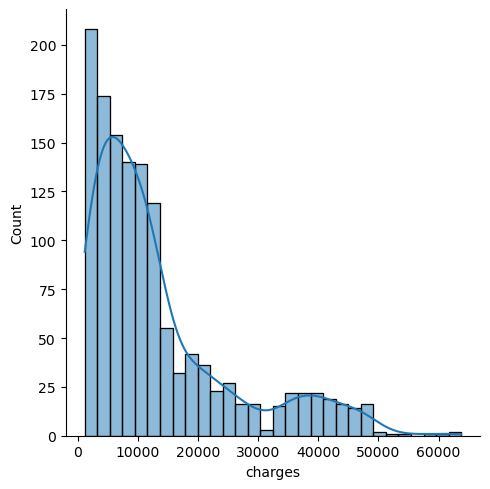

In [3]:
sns.displot(data.charges, kde=True)

We would like to predict the insurance charge given the information: age, sex, bmi, number of children children, smoker, and region  
Region, Sex, and number of children are non-informative priors, so we'll disclude them from the model  
### Prior:  
$ \beta_1 \sim Gamma(10,1) $ Age weight  
$ \beta_2 \sim Gamma(15,4) $ Smoker weight  
$ \beta_3 \sim Gamma(10,1) $ BMI weight  
$ \sigma^2 \sim Gamma(10,4) $ Y-intercept  
### Posterior:  
$ y \sim Normal(\beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3, \sigma^2) $  

In [142]:
def prior_func():
    beta = rng.gamma(0.3, 2) # age weight
    s = rng.normal(0.79, 1) # smokes
    bmi = rng.gamma(0.2, 3) # bmi weight
    # b0 = rng.normal(0, 1) # y-intercept
    b0 = np.sqrt(np.power(rng.gamma(1,1), -1)) # scale
    return np.array([beta, s, bmi, b0])

prior = Prior(prior_fun=prior_func, param_names=["beta", "smokes", "bmi", "b0"])
# f = prior.plot_prior2d()

In [143]:
def simulate(params, n_obs=300):
    # sample ages, smokers, and bmi
    ages = rng.uniform(18, 65, size=n_obs)
    smokes = rng.binomial(1, 0.2, size=n_obs) # 1 -> smoker
    bmis = rng.normal(30, 3, size=n_obs)
    # return draw for posterior
    res = np.zeros((n_obs, len(params-1)))
    res[:,0] = rng.normal(ages * params[0], params[3])
    res[:,1] = rng.normal(smokes * params[1], params[3])
    res[:,2] = rng.normal(bmis * params[2], params[3])
    # res[:,3] = rng.normal(bmis * params[3], params[4])
    return res

simulator = Simulator(simulator_fun=simulate)

In [144]:
model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 300, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [145]:
# debug shape
sim_data = model(4)['sim_data']
sim_data.shape

(4, 300, 4)

In [146]:
summary_net = DeepSet()
inference_net = InvertibleNetwork(
    num_params=len(prior.param_names), 
    num_coupling_layers=6,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": True}
)
amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

In [147]:
trainer = Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [148]:
history = trainer.train_online(epochs=10, iterations_per_epoch=1000, batch_size=32, validation_sims=200)
winsound.MessageBeep()

INFO:root:Generated 200 simulations for validation.
Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.92it/s, Epoch: 1, Iter: 1000,Loss: -4.746,Avg.Loss: 339.012,LR: 4.88E-04]   
INFO:root:Validation, Epoch: 1, Loss: -4.934
Training epoch 2: 100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s, Epoch: 2, Iter: 1000,Loss: -5.561,Avg.Loss: -4.901,LR: 4.52E-04]
INFO:root:Validation, Epoch: 2, Loss: -5.759
Training epoch 3: 100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s, Epoch: 3, Iter: 1000,Loss: -4.472,Avg.Loss: -5.241,LR: 3.97E-04]
INFO:root:Validation, Epoch: 3, Loss: -5.873
Training epoch 4: 100%|██████████| 1000/1000 [00:37<00:00, 26.85it/s, Epoch: 4, Iter: 1000,Loss: -4.981,Avg.Loss: -5.658,LR: 3.27E-04]
INFO:root:Validation, Epoch: 4, Loss: -5.133
Training epoch 5: 100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s, Epoch: 5, Iter: 1000,Loss: -5.760,Avg.Loss: -5.908,LR: 2.50E-04]
INFO:root:Validation, Epoch: 5, Loss: -6.420
Training epoch 6: 100%|██████████| 1000/1000 [00:37<00:00, 26.77it/s, Epoch: 6, Iter: 1000,Loss:

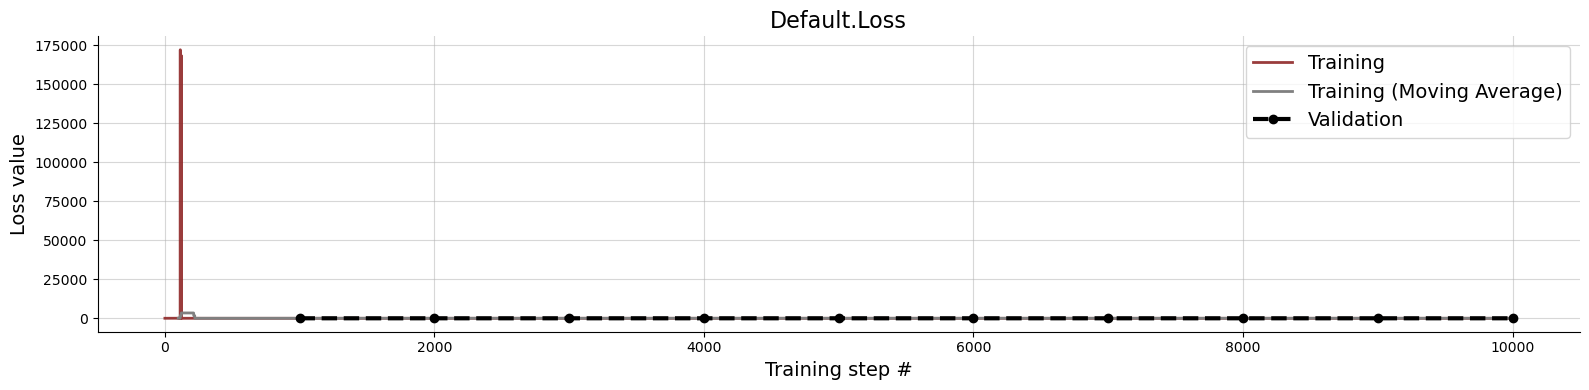

In [149]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True)

dict_keys(['summary_conditions', 'direct_conditions', 'parameters'])
(300, 4)


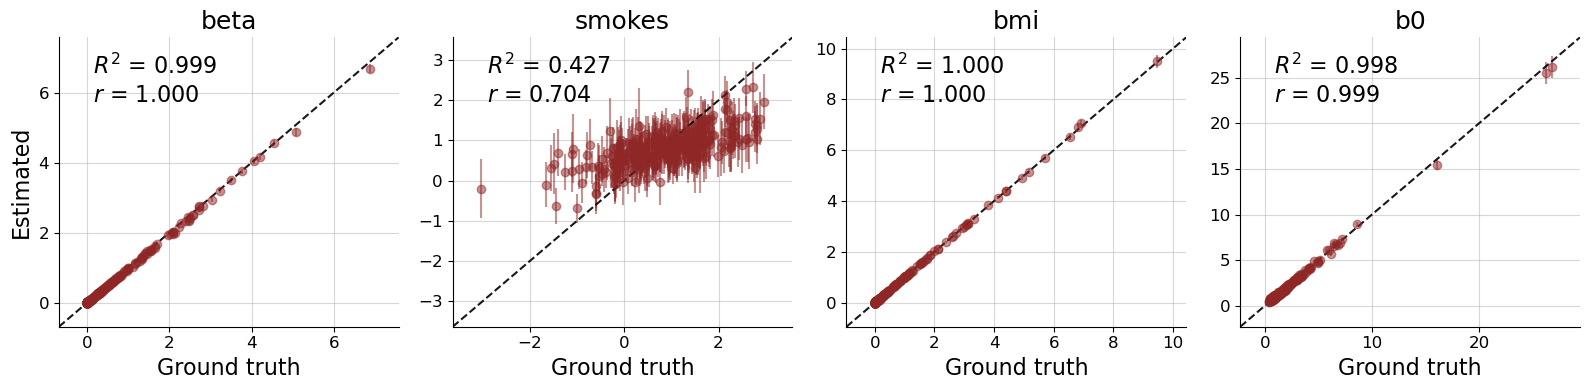

In [150]:
validation_sims = trainer.configurator(model(batch_size=300))
post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = bf.diagnostics.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)
print(validation_sims.keys())
params = validation_sims['parameters']
print(params.shape)

C:\Users\grajec\AppData\Local\Temp\ipykernel_23728\2148044779.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_data = training_data.replace({'yes': 1, 'no': 0})
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final

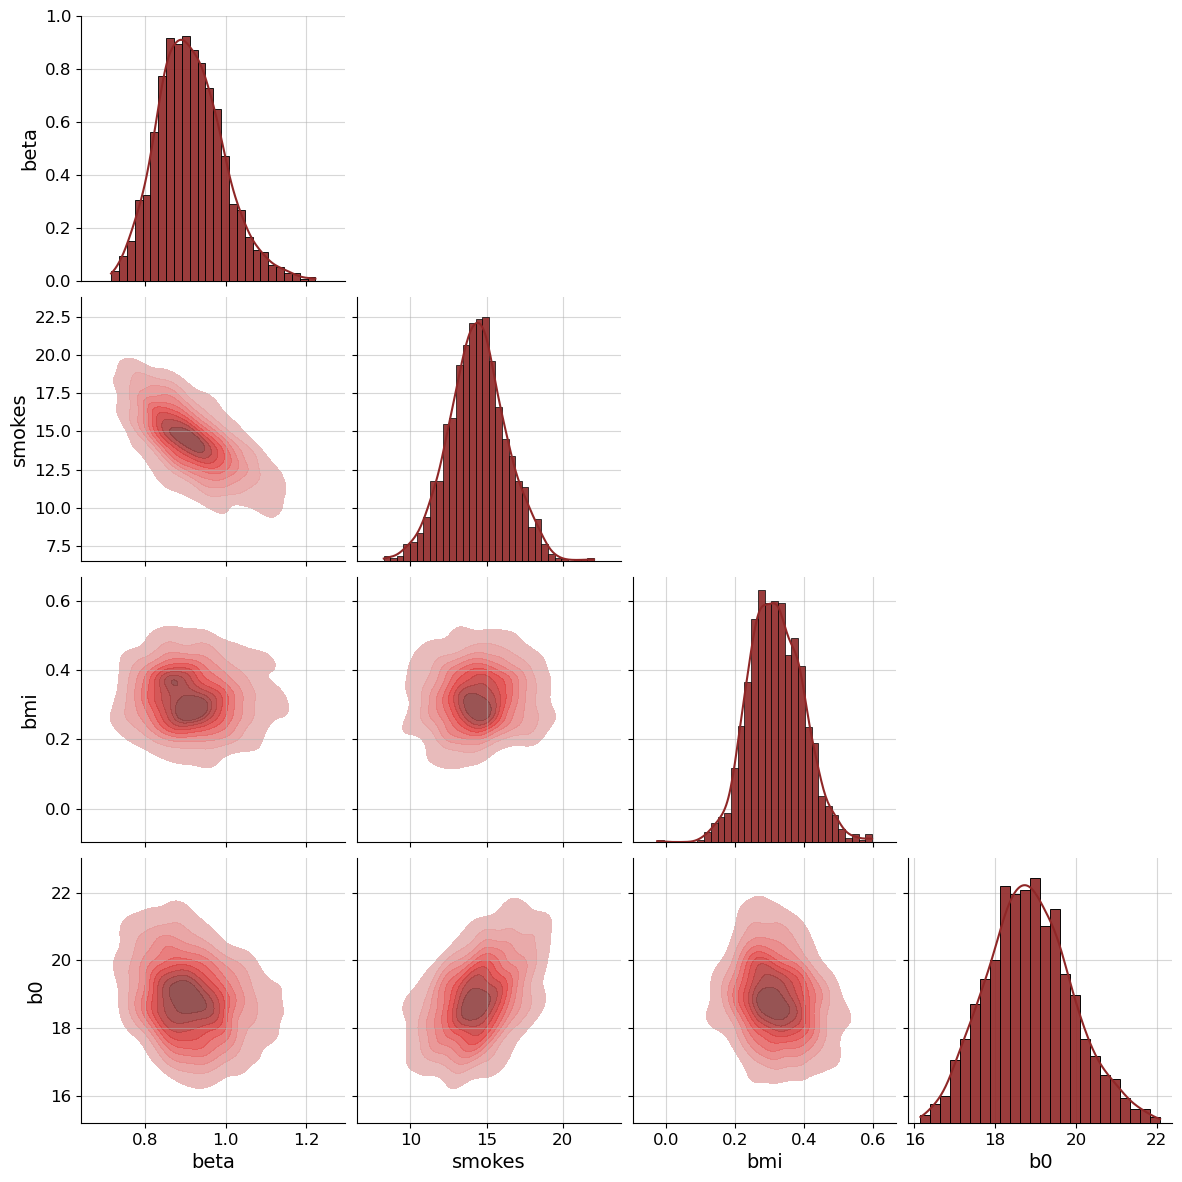

In [180]:
# Inspect trained posterior against real data
training_data = data
training_data = training_data.replace({'yes': 1, 'no': 0})
training_data = training_data.drop(columns=["sex", "region", "children"])
# age, smoke, bmi, charge
training_data.charges = (training_data.charges - training_data.charges.mean()) / training_data.charges.std()
# training_data.age = (training_data.age - training_data.age.mean()) / training_data.age.std()
# training_data.bmi = (training_data.bmi - training_data.bmi.mean()) / training_data.bmi.std()
training_data = training_data.to_numpy()


post_samples = amortizer.sample({'summary_conditions': np.asarray([training_data])}, n_samples=1338)
f = bf.diagnostics.plot_posterior_2d(post_samples, param_names=prior.param_names)

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seabor

<Axes: xlabel='charges', ylabel='Count'>

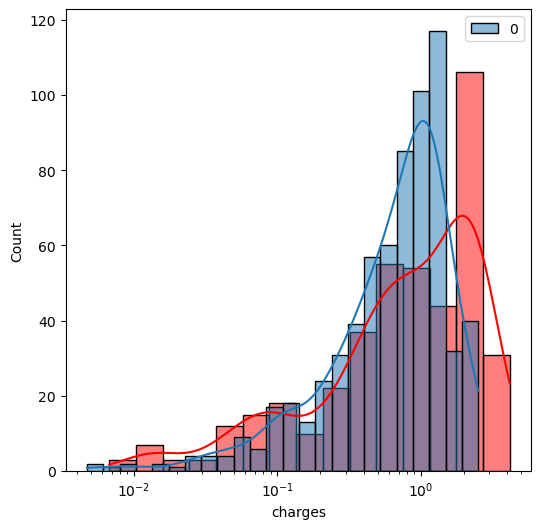

In [198]:
n_samples = post_samples.shape[0]
avg_beta = sum(sample[0] for sample in post_samples) / n_samples
avg_s = sum(sample[1] for sample in post_samples) / n_samples
avg_bmi = sum(sample[2] for sample in post_samples) / n_samples
avg_b0 = sum(sample[3] for sample in post_samples) / n_samples


learned_data = np.zeros((n_samples, 1))
ages = rng.uniform(18, 65, size=n_samples)
bmis = rng.normal(30, 3, size=n_samples)
smokes = rng.binomial(1, 0.2, size=n_samples)
sexes = rng.binomial(1, 0.5, size=n_samples)
for i in range(n_samples):
    learned_data[i] = (avg_beta * ages[i]) + (avg_s * smokes[i]) + (avg_bmi * bmis[i]) + avg_b0

fig, ax = plt.subplots(1,1,figsize=(6,6))
norm_charges = (data.charges - data.charges.mean()) / data.charges.std()
learned_data = (learned_data - learned_data.mean()) / learned_data.std()
# reg_charges = np.log(data.charges)
sns.histplot(norm_charges, log_scale=True, color='red', kde=True, ax=ax)
sns.histplot(learned_data, log_scale=True, color='blue', kde=True, ax=ax)

In [202]:
# fig, ax = plt.subplots(1,1,figsize=(6,6))
# print(data.charges.to_numpy().shape)
# sns.regplot(x=norm_charges, y=learned_data, ax=ax)
# ax.set(xlabel="Ground Truth", ylabel="Predictive Posterior", title="Posterior alignment", yscale='log')

ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 1338 and the vector passed to `y` has length 2000.

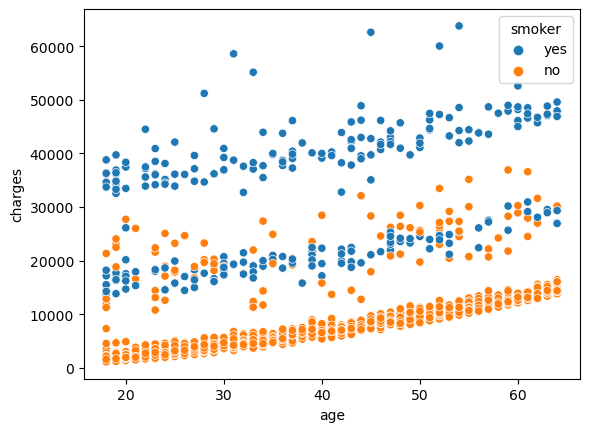

In [54]:
sns.scatterplot(data=data, x='age', y='charges', hue="smoker")

In [598]:
x = np.asarray([[1,2],[2,1]])
rng.normal(x, np.eye(2))

array([[1.22737195, 2.        ],
       [2.        , 4.03544706]])

<Axes: xlabel='bmi', ylabel='charges'>

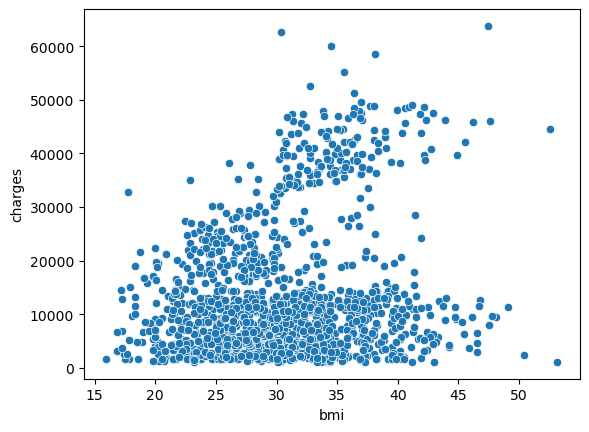

In [421]:
sns.scatterplot(data=data, x='bmi', y='charges')

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

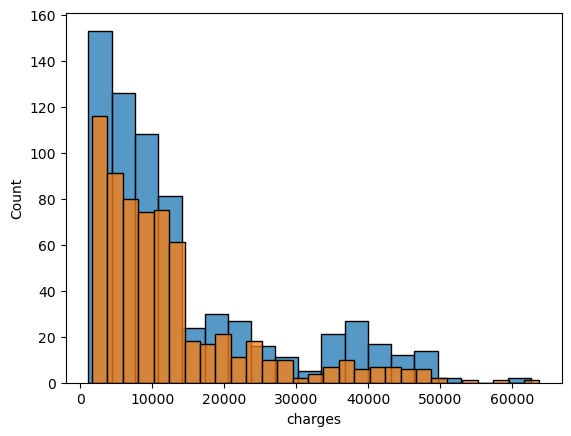

In [422]:
sns.histplot(data[data['sex']=='male']['charges'])
sns.histplot(data[data['sex']=='female']['charges'])

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

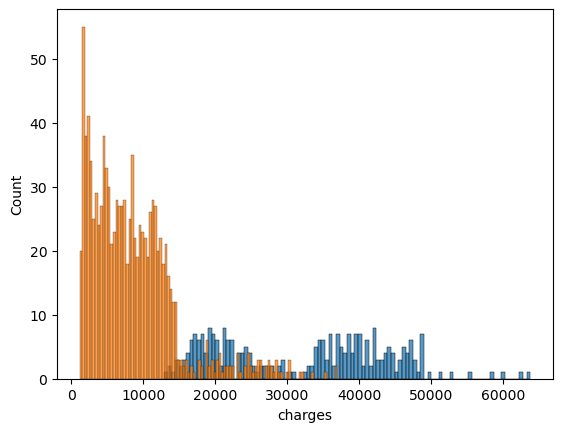

In [423]:
sns.histplot(data[data['smoker']=='yes']['charges'], bins=100)
sns.histplot(data[data['smoker']=='no']['charges'], bins=100)

<Axes: xlabel='children', ylabel='charges'>

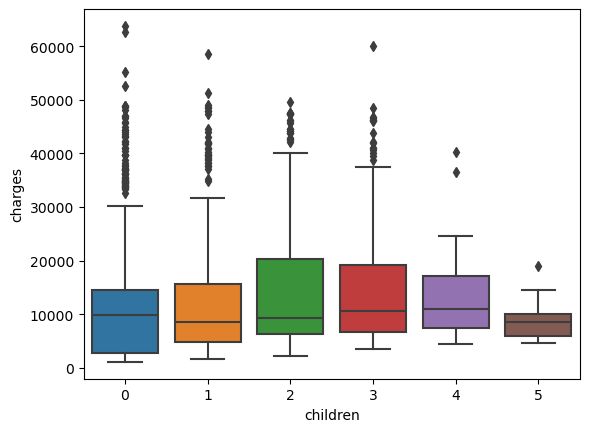

In [424]:
sns.boxplot(data=data, x='children', y='charges')

<Axes: xlabel='region', ylabel='charges'>

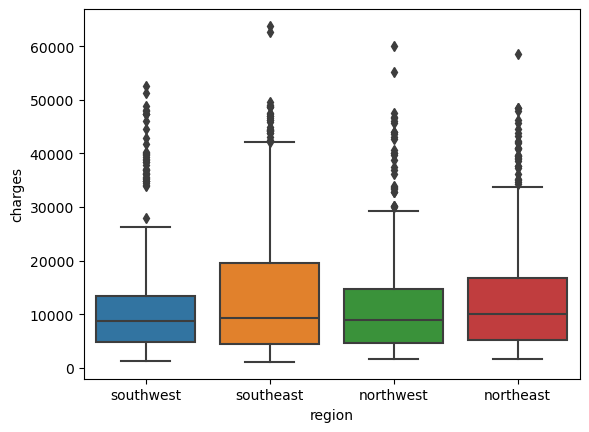

In [425]:
sns.boxplot(data=data, x='region', y='charges')

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

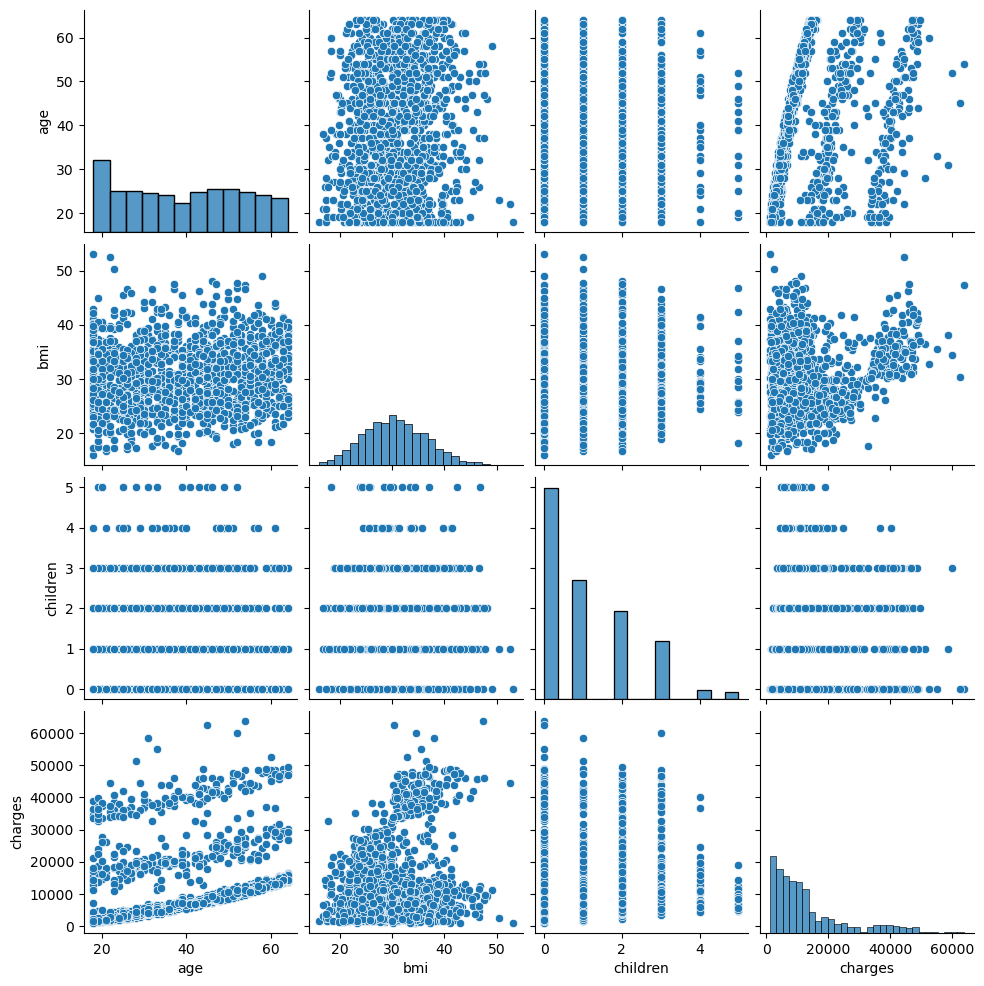

In [426]:
sns.pairplot(data)